In [1]:
# Importing necessary libraries
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16, VGG19, ResNet50, InceptionV3, Xception
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

# Setting random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Define constants
NUM_CLASSES = 2
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
TRAIN_DIR = 'train'
VAL_DIR = 'val'
TEST_DIR = 'test'
TRAIN_SPLIT = 0.7
VAL_SPLIT = 0.1
TEST_SPLIT = 0.2
test_samples = 280

In [2]:
# Define the base directory where the image data is located
BASE_DIR = r"C:\Users\mohit\Downloads\DIP Assignment 2\Data"

In [3]:
# Set the paths for training, validation, and test data
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VAL_DIR = os.path.join(BASE_DIR, 'val')
TEST_DIR = os.path.join(BASE_DIR, 'test')

In [4]:
# Load and preprocess the data
train_datagen = ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
train_generator = train_datagen.flow_from_directory(TRAIN_DIR,target_size=IMG_SIZE,batch_size=BATCH_SIZE,class_mode='categorical')

val_generator = val_datagen.flow_from_directory(VAL_DIR,target_size=IMG_SIZE,batch_size=BATCH_SIZE,class_mode='categorical')

test_generator = test_datagen.flow_from_directory(TEST_DIR,target_size=IMG_SIZE,batch_size=BATCH_SIZE,class_mode='categorical',shuffle=False)

Found 980 images belonging to 2 classes.
Found 140 images belonging to 2 classes.
Found 280 images belonging to 2 classes.


In [6]:
# Define function for creating transfer learning models
def create_transfer_model(base_model, num_classes):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [7]:
# Define InceptionV3 model
inceptionv3_base = InceptionV3(include_top=False, weights='imagenet', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
inceptionv3_model = create_transfer_model(inceptionv3_base, NUM_CLASSES)

In [8]:
# Compile the models
optimizer = Adam(learning_rate=0.0001)
inceptionv3_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# Define checkpoint callback to save the best model during training
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

In [10]:
# Train the models
inceptionv3_history = inceptionv3_model.fit_generator(train_generator, steps_per_epoch=train_generator.n // train_generator.batch_size, epochs=10, validation_data=val_generator, validation_steps=val_generator.n // val_generator.batch_size, callbacks=[checkpoint])

C:\Users\mohit\AppData\Local\Temp\ipykernel_34676\918017655.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  inceptionv3_history = inceptionv3_model.fit_generator(train_generator, steps_per_epoch=train_generator.n // train_generator.batch_size, epochs=10, validation_data=val_generator, validation_steps=val_generator.n // val_generator.batch_size, callbacks=[checkpoint])


Epoch 1/10
30/30 [==============================] - 110s 4s/step - loss: 0.1248 - accuracy: 0.9420 - val_loss: 0.0394 - val_accuracy: 0.9922
Epoch 2/10
30/30 [==============================] - 112s 4s/step - loss: 0.0094 - accuracy: 0.9979 - val_loss: 0.0310 - val_accuracy: 0.9922
Epoch 3/10
30/30 [==============================] - 112s 4s/step - loss: 0.0092 - accuracy: 0.9968 - val_loss: 0.0544 - val_accuracy: 0.9922
Epoch 4/10
30/30 [==============================] - 112s 4s/step - loss: 0.0117 - accuracy: 0.9979 - val_loss: 6.0826e-04 - val_accuracy: 1.0000
Epoch 5/10
30/30 [==============================] - 111s 4s/step - loss: 0.0068 - accuracy: 0.9979 - val_loss: 0.0132 - val_accuracy: 0.9922
Epoch 6/10
30/30 [==============================] - 111s 4s/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0223 - val_accuracy: 0.9844
Epoch 7/10
30/30 [==============================] - 113s 4s/step - loss: 0.0056 - accuracy: 0.9968 - val_loss: 7.1364e-04 - val_accuracy: 1.0000
Epoch

In [11]:
inceptionv3_scores = inceptionv3_model.evaluate_generator(test_generator, steps=test_samples // BATCH_SIZE)
print("inceptionv3 Test Loss:", inceptionv3_scores[0])
print("inceptionv3 Test Accuracy:", inceptionv3_scores[1])

C:\Users\mohit\AppData\Local\Temp\ipykernel_34676\1195483549.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  inceptionv3_scores = inceptionv3_model.evaluate_generator(test_generator, steps=test_samples // BATCH_SIZE)


inceptionv3 Test Loss: 0.0008152585942298174
inceptionv3 Test Accuracy: 1.0


In [12]:
# Get the number of test samples
num_test_samples = test_generator.n

# Calculate the number of steps for prediction
num_prediction_steps = num_test_samples // test_generator.batch_size + 1

# Generate predictions for all test samples
inceptionv3_predictions = inceptionv3_model.predict_generator(test_generator, steps=num_prediction_steps, verbose=1)

# Convert predictions to class labels
inceptionv3_predicted_labels = np.argmax(inceptionv3_predictions, axis=1)

C:\Users\mohit\AppData\Local\Temp\ipykernel_34676\2714831293.py:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  inceptionv3_predictions = inceptionv3_model.predict_generator(test_generator, steps=num_prediction_steps, verbose=1)


9/9 [==============================] - 6s 613ms/step


In [13]:
# Get true class labels
true_labels = test_generator.classes

In [14]:
# Calculate classification report
inceptionv3_report = classification_report(true_labels, inceptionv3_predicted_labels)

In [15]:
print("inception Classification Report:")
print(inceptionv3_report)

inception Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       140
           1       1.00      1.00      1.00       140

    accuracy                           1.00       280
   macro avg       1.00      1.00      1.00       280
weighted avg       1.00      1.00      1.00       280



In [16]:
inceptionv3_scores = inceptionv3_model.evaluate_generator(test_generator, steps=test_samples // BATCH_SIZE)
print("inceptionv3 Test Loss:", inceptionv3_scores[0])
print("inceptionv3 Test Accuracy:", inceptionv3_scores[1])

C:\Users\mohit\AppData\Local\Temp\ipykernel_34676\1195483549.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  inceptionv3_scores = inceptionv3_model.evaluate_generator(test_generator, steps=test_samples // BATCH_SIZE)


inceptionv3 Test Loss: 0.0008152585942298174
inceptionv3 Test Accuracy: 1.0


In [17]:
from PIL import Image

# Load the image
image = Image.open(r"C:\Users\mohit\Downloads\DIP Assignment 2\Data\test\pneumonia\person518_bacteria_2197.jpeg")

In [18]:
from keras.applications.vgg16 import preprocess_input

# Resize the image to match the input size of VGG16 model
image = image.resize((224, 224))

# Convert the image to numpy array
image_array = np.array(image)

# Preprocess the image to match the preprocessing applied during training
image_preprocessed = preprocess_input(image_array)

In [19]:
# Make predictions using the trained models
inceptionv3_prediction = inceptionv3_model.predict(np.expand_dims(image_preprocessed, axis=0))

# Convert the predictions to class labels
inceptionv3_predicted_label = np.argmax(inceptionv3_prediction, axis=1)

# Print the predicted class labels
print("InceptionV3 predicted class label:", inceptionv3_predicted_label)

ValueError: in user code:

    File "C:\Users\mohit\anaconda3\lib\site-packages\keras\engine\training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\mohit\anaconda3\lib\site-packages\keras\engine\training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\mohit\anaconda3\lib\site-packages\keras\engine\training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\mohit\anaconda3\lib\site-packages\keras\engine\training.py", line 2079, in predict_step
        return self(x, training=False)
    File "C:\Users\mohit\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\mohit\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 250, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'model' (type Functional).
    
    Input 0 of layer "conv2d" is incompatible with the layer: expected min_ndim=4, found ndim=3. Full shape received: (None, 224, 224)
    
    Call arguments received by layer 'model' (type Functional):
      • inputs=tf.Tensor(shape=(None, 224, 224), dtype=float32)
      • training=False
      • mask=None


In [21]:
from PIL import Image
import numpy as np
from keras.applications.vgg16 import preprocess_input

# Load the image
image = Image.open(r"C:\Users\mohit\Downloads\DIP Assignment 2\Data\test\pneumonia\person518_bacteria_2197.jpeg")

# Resize the image to match the input size of VGG16 model
image = image.resize((224, 224))

# Convert the image to numpy array
image_array = np.array(image)

# Add channel dimension to the image array
image_array = np.expand_dims(image_array, axis=-1)

# Repeat the channel dimension 3 times to match the expected input shape of (None, 224, 224, 3)
image_array = np.repeat(image_array, 3, axis=-1)

# Preprocess the image to match the preprocessing applied during training
image_preprocessed = preprocess_input(image_array)

# Make predictions using the trained models
inceptionv3_prediction = inceptionv3_model.predict(image_preprocessed)

# Convert the predictions to class labels
inceptionv3_predicted_label = np.argmax(inceptionv3_prediction, axis=1)

# Print the predicted class labels
print("InceptionV3 predicted class label:", inceptionv3_predicted_label)

ValueError: in user code:

    File "C:\Users\mohit\anaconda3\lib\site-packages\keras\engine\training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\mohit\anaconda3\lib\site-packages\keras\engine\training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\mohit\anaconda3\lib\site-packages\keras\engine\training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\mohit\anaconda3\lib\site-packages\keras\engine\training.py", line 2079, in predict_step
        return self(x, training=False)
    File "C:\Users\mohit\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\mohit\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(32, 224, 3)


In [22]:
from PIL import Image
import numpy as np
from keras.applications.vgg16 import preprocess_input

# Load the image
image = Image.open(r"C:\Users\mohit\Downloads\DIP Assignment 2\Data\test\pneumonia\person518_bacteria_2197.jpeg")  # Replace "test_image.jpg" with the path to your test image

# Resize the image while maintaining its aspect ratio
image.thumbnail((224, 224))

# Convert the image to numpy array
image_array = np.array(image)

# Check if the image has 3 channels (RGB)
if image_array.shape[-1] != 3:
    # Convert grayscale image to RGB by stacking the array along the channel axis 3 times
    image_array = np.stack((image_array,) * 3, axis=-1)

# Preprocess the image to match the preprocessing applied during training
image_preprocessed = preprocess_input(image_array)

# Make predictions using the trained models
inceptionv3_prediction = inceptionv3_model.predict(np.array([image_preprocessed]))

# Convert the predictions to class labels
inceptionv3_predicted_label = np.argmax(inceptionv3_prediction, axis=1)

# Print the predicted class labels
print("InceptionV3 predicted class label:", inceptionv3_predicted_label)

ValueError: in user code:

    File "C:\Users\mohit\anaconda3\lib\site-packages\keras\engine\training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\mohit\anaconda3\lib\site-packages\keras\engine\training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\mohit\anaconda3\lib\site-packages\keras\engine\training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\mohit\anaconda3\lib\site-packages\keras\engine\training.py", line 2079, in predict_step
        return self(x, training=False)
    File "C:\Users\mohit\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\mohit\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 167, 224, 3)


Epoch 1/5
30/30 [==============================] - 96s 3s/step - loss: 0.0055 - accuracy: 0.9979
Epoch 2/5
30/30 [==============================] - 107s 4s/step - loss: 0.0020 - accuracy: 0.9989
Epoch 3/5
30/30 [==============================] - 109s 4s/step - loss: 0.0011 - accuracy: 1.0000
Epoch 4/5
30/30 [==============================] - 111s 4s/step - loss: 0.0012 - accuracy: 1.0000
Epoch 5/5
30/30 [==============================] - 108s 4s/step - loss: 0.0059 - accuracy: 0.9979


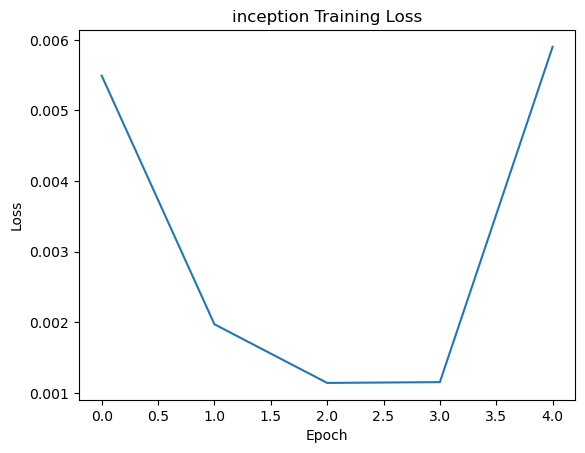

In [28]:
import matplotlib.pyplot as plt

# Train the VGG16 model and obtain the training history
inceptionv3_history = inceptionv3_model.fit(train_generator, steps_per_epoch=train_generator.n // train_generator.batch_size, epochs=5)

# Plot the training loss curve
plt.plot(inceptionv3_history.history['loss'])
plt.title('inception Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

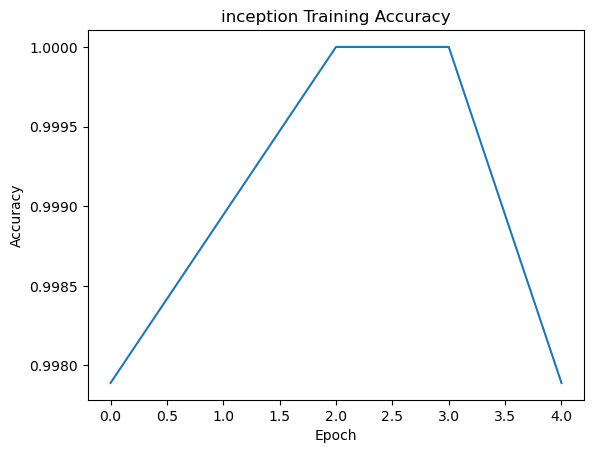

In [30]:
# Train the VGG16 model and obtain the training history
#inceptionv3_history = inceptionv3_model.fit(train_generator, steps_per_epoch=train_generator.n // train_generator.batch_size, epochs=5)

plt.plot(inceptionv3_history.history['accuracy'])
plt.title('inception Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()